In [453]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

## Loading and merging data

In [577]:
df_geo = pd.read_excel('./HF - complete.xlsx', sheet_name='Geography')
df_geo_london = df_geo[df_geo['Manager City'].isin(['London','City Of London'])]

df_strategy = pd.read_excel('./HF - complete.xlsx', sheet_name='Investment Strategy&Returns')
df_aum = pd.read_excel('./HF - complete.xlsx', sheet_name='HF info - AUM')


In [578]:
df = df_geo_london.merge(df_strategy, how='left', on=['Ticker','Name'])
df = df.merge(df_aum.drop(columns='AUM (USD)'), how='left', on=['Ticker', 'Name'])

In [579]:
# df_bu = df.copy()

In [569]:
df = df_bu.copy()

In [580]:
def to_nominal_aum(df_input):
    
    df = df_input.copy()
    df = df.rename(columns={'AUM (USD)' : 'AUM'})
    df['AUM'] = df['AUM'].astype('str')

    df.loc[df['AUM'].str.contains('B'),'UNIT'] = 'B'
    df.loc[df['AUM'].str.contains('M'),'UNIT'] = 'M'
    df.loc[df['AUM'].str.contains('k'),'UNIT'] = 'k'

    df['AUM'] = df['AUM'].apply(lambda x: x.replace('B',''))
    df['AUM'] = df['AUM'].apply(lambda x: x.replace('M',''))
    df['AUM'] = df['AUM'].apply(lambda x: x.replace('k',''))
    df['AUM'] = df['AUM'].apply(lambda x: x.replace('--','0'))

    df['AUM'] = df['AUM'].astype('float')

    df.loc[df.UNIT=='B', 'AUM'] = df['AUM']*1e9
    df.loc[df.UNIT=='M', 'AUM'] = df['AUM']*1e6
    df.loc[df.UNIT=='k', 'AUM'] = df['AUM']*1e3
    
    
    return(df)

# Data inspection and cleaning

**Data are structured in the following way:**

- Ticker is the unique identifier for the FUND (Name corresponds to the fund name, not the hedge fund)
- Management Company is the Hedge Fund/Asset manager that manages the investment fund
- A Management Company therefore can have multiple funds - especailly true for big HFs


**Data cleaning:**

- Need to convert AUM columns from string to numeric (function "to_nominal_aum")
- Conversion AUM to milion USD
- Removing funds with 0USD AUM
- Only look at London's funds - already filtered at the beginning


**Data visualisation**:
- Clipping the distribution to $500M (that's the reason of the pick at 500M). It is very long tailed distribution, easier to look at

In [581]:
# df = df_strat[df_strat.AUM<(1e9)].copy()
# df_strat = df_strat[df_strat.AUM>(1e5)]
df = to_nominal_aum(df)

In [582]:
df['AUM'] = df.AUM*1e-6

In [ ]:
df['1M Ret'] = df['1M Ret'].apply(lambda x: (x.split('%')[0]).replace('--', '0')).astype(float)
df['YTD Ret'] = df['YTD Ret'].apply(lambda x: (x.split('%')[0]).replace('--', '0')).astype(float)

### Starting with visualising the distribution with all the outliers
- There are plenty of companies with artificially low AUM (to remove)
- Too big funds need to be filtered out (they're not interesting to us)
- In general the distribution is very skewed, so makes more sense looking at the median rather than mean


In [583]:
df.describe()

,AUM
count,1007.000000
mean,236.212442
std,1038.989255
min,0.000000
25%,0.000000
50%,9.920000
75%,113.960000
max,22680.000000


Text(0.5, 0, 'AUM (M$)')

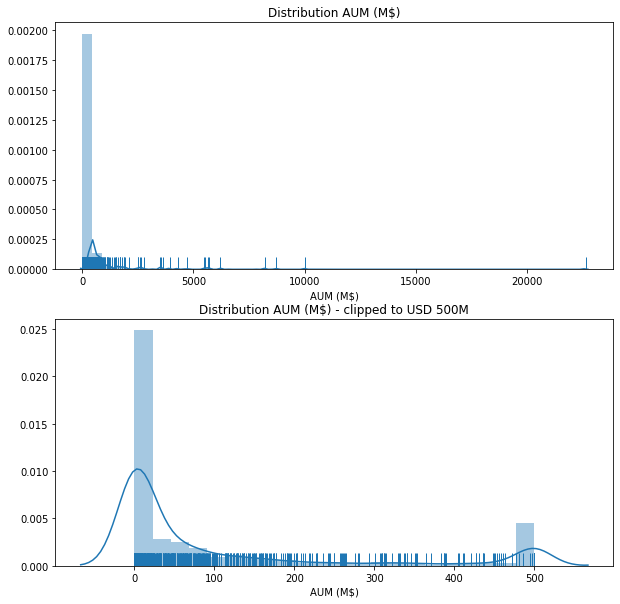

In [584]:
f,ax= plt.subplots(2,1,figsize=(10,10))
sns.distplot(df['AUM'], ax=ax[0], rug=True)
ax[0].set_title('Distribution AUM (M$)')
ax[0].set_xlabel('AUM (M$)')


sns.distplot(df['AUM'].clip(0,500), ax=ax[1], rug=True)
ax[1].set_title('Distribution AUM (M$) - clipped to USD 500M')
ax[1].set_xlabel('AUM (M$)')

## Distribution AUM by asset manager

- We only care about the HFs, not the single funds, so let's aggregate everything up
- Be careful: return are in % not nominal

In [585]:
import numpy as np

In [612]:
df_hf = df.groupby('Management Company').agg({'Ticker':'count',
                                              'AUM':'sum',
                                              '1M Ret':'mean',
                                              'YTD Ret':'mean'
                                             })

In [613]:
df_hf = df_hf[df_hf.index!='--']

In [614]:
df_hf = df_hf[df_hf.AUM > 1]

## Filtering

It's clear we need to focus where most of the market players are: few milions to 

- Removing all HFs with AUM < USD 1M - this are simply wrong data, or way too small HFs

From the distribution below it's clear we need to focus only on HFs with AUM below USD 2B

Text(0.5, 0, 'AUM (M$)')

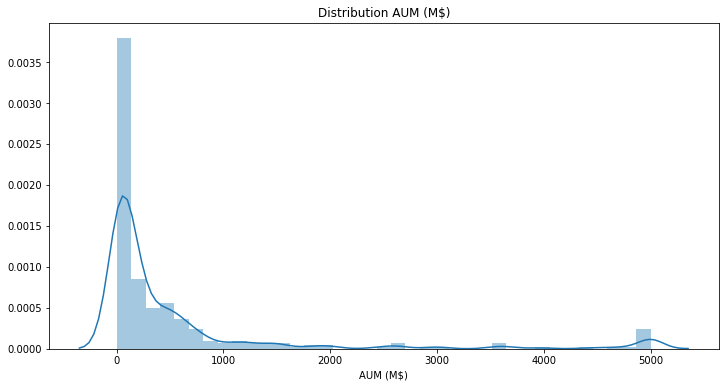

In [618]:
f,ax= plt.subplots(figsize=(12,6))
sns.distplot(df_hf['AUM'].clip(0,5000))
ax.set_title('Distribution AUM (M$)')
ax.set_xlabel('AUM (M$)')

In [600]:
df_hf.describe()

,Ticker,AUM,1M Ret,YTD Ret
count,526.000000,526.000000,526.000000,526.000000
mean,1.884030,448.794446,0.094598,2.691969
std,2.220221,1666.275424,3.220741,8.648460
min,1.000000,0.000000,-49.525000,-80.615000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,22.600000,0.000000,0.000000
75%,2.000000,210.697500,0.317500,3.202500
max,27.000000,22895.340000,19.000000,82.550000


In [619]:
df_hf_filt = df_hf.copy()
df_hf_filt = df_hf_filt[df_hf_filt.AUM<2000]

In [620]:
df_hf_filt.describe()

,Ticker,AUM,1M Ret,YTD Ret
count,305.000000,305.000000,305.000000,305.000000
mean,1.845902,274.572986,-0.006016,3.291989
std,1.677794,373.973802,4.067269,9.550805
min,1.000000,1.120000,-49.525000,-80.615000
25%,1.000000,28.140000,-0.107500,0.000000
50%,1.000000,117.600000,0.000000,0.730000
75%,2.000000,406.260000,0.490000,5.245556
max,12.000000,1984.890000,19.000000,82.550000


## Key results

From the distribution below I think we'd need to direct our research on HFs with USD 500M +/- 300M.
These are potentially the HFs with higher power to buy a product like oursì. More cash to invest

Text(0.5, 0, 'AUM (M$)')

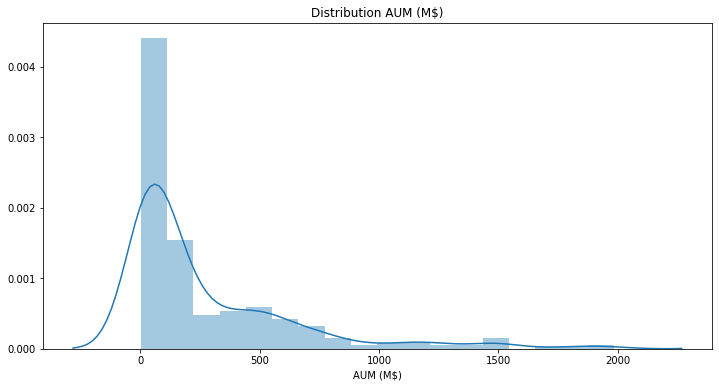

In [623]:
f,ax= plt.subplots(figsize=(12,6))
sns.distplot(df_hf_filt['AUM'])
ax.set_title('Distribution AUM (M$)')
ax.set_xlabel('AUM (M$)')

**Few names to check**

In [633]:
df_hf_filt[df_hf_filt.AUM>400].sort_values('AUM',ascending=True).head(20)


,Ticker,AUM,1M Ret,YTD Ret
Management Company,,,,
Liontrust Multi-Asset Ltd,1,406.26,0.620000,6.370000
Cheyne Capital Management Ltd,1,412.68,3.070000,4.920000
CQS Cayman LP,1,427.00,0.000000,0.000000
Culross Global Management Ltd,3,428.00,-0.720000,-0.393333
Marshall Wace Asset Management Ireland Ltd,1,430.57,0.930000,12.210000
Dearborn Capital Management LLC,1,437.76,-1.770000,3.550000
Algebris UK Ltd,1,448.91,0.000000,2.070000
Camox Cayman Management Ltd,1,450.00,-1.620000,10.610000
Pamplona Capital Management LLP,1,451.25,0.000000,0.000000


In [634]:
df_geo[df_geo['Management Company']=='Selwood Asset Management LLP']

,Name,Ticker,Management Company,Manager City,Manager Country,Prime Broker,Auditor,Administrator,Custodian,Legal Counsel
988,Selwood Credit Opportunities Feeder Sub-Fund IV,SCO4IRU ID,Selwood Asset Management LLP,London,United Kingdom,Bank of America Merrill Lynch/,Deloitte & Touche LLP,US Bank Global Fund Services Ireland Ltd,Bank of America Merrill Lynch/Cayman Islands,Maples and Calder Ltd
1343,Selwood Credit Opportunities Feeder Sub-Fund III,SCOF3MU ID,Selwood Asset Management LLP,London,United Kingdom,Bank of America Corp,Deloitte & Touche LLP,US Bank Global Fund Services Ireland Ltd,Bank of America Corp,Maples and Calder Ltd


# AUM by strategy

In [637]:
df_filt = df.copy()
df_filt = df_filt[df_filt.AUM<2000]
df_filt = df_filt[df_filt.AUM>1]

In [639]:
df_filt.columns

Index(['Name', 'Ticker', 'Management Company', 'Manager City',
       'Manager Country', 'Prime Broker', 'Auditor', 'Administrator',
       'Custodian', 'Legal Counsel', 'Strategy', 'Style', '1M Ret', 'YTD Ret',
       'AUM', 'Last Close Dt', 'Fund Type', 'Geo Focus', 'Industry Focus',
       'Firm AUM (USD)', 'Inception Date', 'Market Status', 'Closed',
       'Women/Minority', 'Index Constituent', 'Permissioning Status',
       'Primary Share Classes', 'Investor Type', 'Px Source', 'UNIT'],
      dtype='object')

In [651]:
by_strategy = df.groupby('Style')['AUM'].sum()
by_strategy = by_strategy[by_strategy.index!='--']

In [652]:
by_strategy = by_strategy.to_frame('AUM').reset_index().sort_values('AUM', ascending=False)

[Text(0, 0, 'Multi-Strategy'),
 Text(0, 0, 'Equity Long/Short'),
 Text(0, 0, 'Macro Multi-Strategy'),
 Text(0, 0, 'Discretionary Macro'),
 Text(0, 0, 'Equity Long Only'),
 Text(0, 0, 'Commodity Trading Advisors (CTA)'),
 Text(0, 0, 'Fundamental Equity Market Neutral'),
 Text(0, 0, 'Fixed Income Arbitrage'),
 Text(0, 0, 'Distressed Debt'),
 Text(0, 0, 'Insurance'),
 Text(0, 0, 'Structured Credit'),
 Text(0, 0, 'Credit Hedge Multi-Strategy'),
 Text(0, 0, 'Equity Long Biased'),
 Text(0, 0, 'Global Asset Allocation (GAA)'),
 Text(0, 0, 'Emerging Market Debt'),
 Text(0, 0, 'Event Driven Multi-Strategy'),
 Text(0, 0, 'Commodity'),
 Text(0, 0, 'Credit Long/Short'),
 Text(0, 0, 'Relative Value Multi-Strategy'),
 Text(0, 0, 'Merger Arbitrage')]

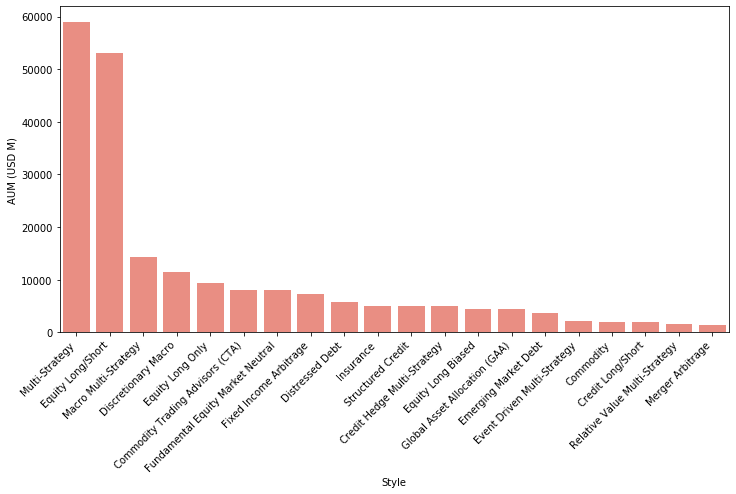

In [661]:
f,ax=plt.subplots(figsize=(12,6))
sns.barplot(data=by_strategy.head(20), x='Style', y='AUM', color='salmon')
ax.set_ylabel('AUM (USD M)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

In [676]:
xx = df_filt[df_filt['Style'].isin(by_strategy.Style[0:10].to_list())]

In [688]:
median_df = xx.groupby('Style').apply(lambda x: x.AUM.median()).to_frame('AUM').reset_index()

[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

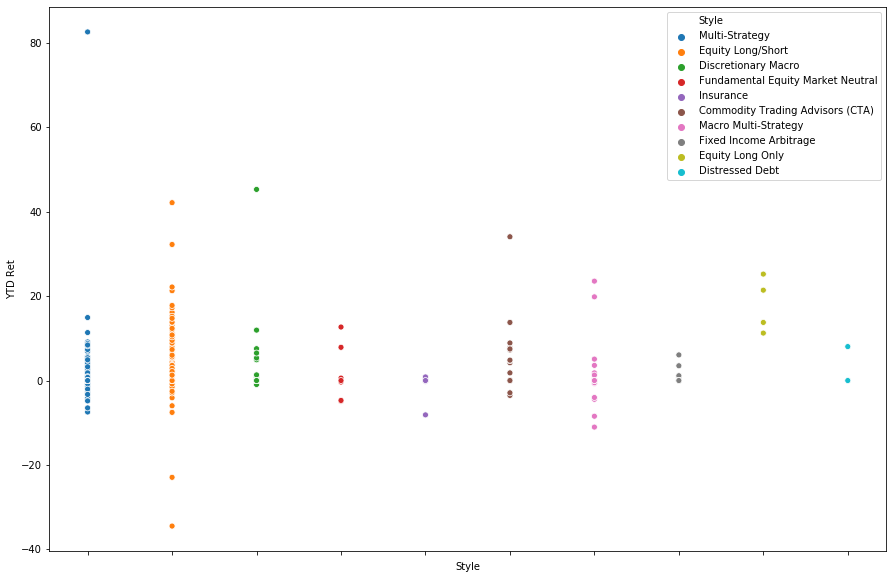

In [699]:
f,ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x=xx['Style'], y=xx['YTD Ret'], hue=xx['Style'],ax=ax)
# sns.scatterplot(data = median_df, x='Style', y='AUM', color='red', size=1000, ax=ax)


ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')